In [24]:
from pathlib import Path
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np

# Attempt to locate the combined CSV anywhere up the tree
def find_file(name, start=Path.cwd()):
    for ancestor in [start] + list(start.parents):
        matches = list(ancestor.rglob(name))
        if matches:
            return matches[0]
    return None

source = find_file("ispu_all_years_max_handled.csv")

# load dataframe (use same NA values as other scripts)
NA_VALUES = ["---", "--", "", " ", "NA", "N/A"]
if source:
    print(f"Loading combined CSV from: {source}")
    df = pd.read_csv(source, na_values=NA_VALUES)
else:
    print("Combined CSV not found; falling back to existing `df` if present in the kernel")
    df = globals().get('df', pd.DataFrame())

print("Loaded columns:", df.columns.tolist())

features = [
    "pm_sepuluh",
    "pm_duakomalima",
    "sulfur_dioksida",
    "karbon_monoksida",
    "ozon",
    "nitrogen_dioksida"
]

target = "kategori"

# Ensure we only select columns that actually exist to avoid KeyError
present_features = [c for c in features if c in df.columns]
missing_features = [c for c in features if c not in df.columns]
if missing_features:
    print(f"Warning: missing feature columns: {missing_features}")

if target not in df.columns:
    print(f"Warning: target column '{target}' not found in loaded dataframe")

if len(present_features) == 0 or target not in df.columns:
    # produce an informative error rather than a KeyError later
    raise KeyError(f"Required columns missing. Present: {df.columns.tolist()}")

# Build model dataframe
df_model = df[present_features + [target]].copy()

print(f"df_model shape: {df_model.shape}; features used: {present_features}")


Loading combined CSV from: c:\Users\veiro\Documents\datavidia\AIR-POLLUTION-PREDICTION-PENYISIHAN-DATAVIDIA-10\ispu_named copy\ispu_all_years_max_handled.csv
Loaded columns: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'pm_duakomalima', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori', 'id']
df_model shape: (16902, 7); features used: ['pm_sepuluh', 'pm_duakomalima', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida']


In [25]:
# convert fitur ke numerik
for col in features:
    if col in df_model.columns:
        df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# drop row tanpa label
df_model = df_model.dropna(subset=[target])

print(f"After dropping rows without target: {len(df_model)} rows remain")


After dropping rows without target: 16902 rows remain


In [26]:
label_map = {
    "BAIK": 0,
    "SEDANG": 1,
    "TIDAK SEHAT": 2,
    "SANGAT TIDAK SEHAT": 3,
    "BERBAHAYA": 4
}

# Map target labels to integers
# Use df_model[target] (already cleaned of NaNs above)
df_model['y_encoded'] = df_model[target].astype(str).str.strip().map(label_map)

# Detect unknown labels that were not mapped
unknown_labels = df_model[df_model['y_encoded'].isna()][target].unique()
if len(unknown_labels) > 0:
    print(f"Warning: Unknown target labels found and will be dropped: {unknown_labels}")
    df_model = df_model[df_model['y_encoded'].notna()].copy()

# Impute features and build X, y
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Use only features that exist in df_model (present_features from first cell)
X = imputer.fit_transform(df_model[present_features])
y = df_model['y_encoded']

print(f"Prepared training data: X.shape={X.shape}, y.shape={y.shape}")
print("Class distribution:")
print(y.value_counts())


Prepared training data: X.shape=(15444, 6), y.shape=(15444,)
Class distribution:
y_encoded
1.0    10468
2.0     2427
0.0     2345
3.0      203
4.0        1
Name: count, dtype: int64


In [27]:
from sklearn.model_selection import train_test_split

# sanity check lengths
if X.shape[0] != len(y):
    raise ValueError(f"Inconsistent sample counts: X={X.shape[0]}, y={len(y)}")

# Decide whether stratification is safe: need at least 2 samples per class
class_counts = y.value_counts()
if class_counts.min() < 2:
    print("Warning: Some classes have fewer than 2 samples. Disabling stratify for train_test_split.")
    stratify_arg = None
else:
    stratify_arg = y

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=stratify_arg
)

print(f"Split: X_train={X_train.shape}, X_test={X_test.shape}, y_train={len(y_train)}, y_test={len(y_test)}")


Split: X_train=(12355, 6), X_test=(3089, 6), y_train=12355, y_test=3089


In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# predict and show classification report
if 'rf' in globals() and 'X_test' in globals():
    y_pred = rf.predict(X_test)
    print(classification_report(y_test, y_pred))
else:
    print('Model or test set not found. Run training cells first.')


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       443
         1.0       0.99      0.99      0.99      2093
         2.0       1.00      0.99      0.99       510
         3.0       1.00      0.95      0.98        43

    accuracy                           0.99      3089
   macro avg       0.99      0.98      0.98      3089
weighted avg       0.99      0.99      0.99      3089



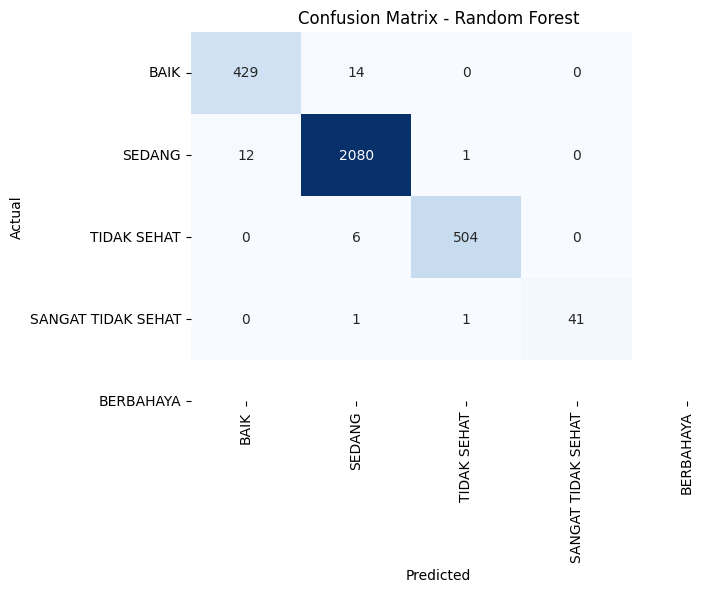

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# ensure confusion_matrix is available
try:
    cm
except NameError:
    try:
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
    except Exception:
        cm = None

if cm is None:
    print('Confusion matrix not available. Ensure predictions were made.')
else:
    labels = list(label_map.keys())
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar=False
    )

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Random Forest")
    plt.show()
